# Loan Repayment Challenge

## 1. Introduction


MoneyLion Data Scientists are constantly working to assess the risk of their applicants more accurately. Being successful in this objective enables them to better price customers and mitigate losses on their portfolio of loans. 

For the following challenge, we will work with a data set of historic loans and loan repayments. The challenge is to assess Loan Risk and Loan Repayment

A few guiding tips:
- ask relevant questions about the data,
- do some preliminary exploration,
- perform the necessary manipulations or aggregations,
- generate visualizations,
- if stuck, describe what additional information or data we might look to collect
- and of course, reach some conclusions or insights about the analysis done.

---

## 2. Executive Summary / TL;DR

The challenge is to assess Loan Risk and Loan Repayment; in other words, do some predictive modelling to try a predict if, given a loan application, can we correctly identify whether or not we should approve the loan?

##### A. Approach:
- I chose to approach this from two angles (what will be referred to as Versions, or V1 and V2). 
- Both Versions entailed a Binary Classification problem to try and predict the outcome of a loan being a success (1) or a failure (0). 
- In both cases, I opted to only consider the loans that got approved and funded, and further, only the ones that were at the end of their observable lifecycle (i.e. ended in being fully paid off, or written off, or somewhere in between).
- The difference in the Versions was how this target column (1 or 0) was constructed:
	- **V1**: target column for prediction was created by checking the loanStatus; success (1) for Fully Paid Off loans, and failure (0) for any loan which entered an undesireable status (such as collections, settlement, written off, etc.)
		- The drawback here is that even loans that ended up being written off may have still made MoneyLion X% of profit before being written off, hence we may not want to count all those out. Thus, V2 was created.
	- **V2**: using the payment.csv data, sum the amount paid for each loan, and then associate a 'ratio of amount paid vs the initial funded amount' (**paidRatio**). Then, for some % threshold (which MoneyLion could easily review and tweak), assign a success (1) or failure (0) based on whether or not sufficient money was repaid from that loan (regardless of the loan status).
		- The drawback here is that even loans that there is no relative weight to these binary results. E.g. a loan that got repaid 130% its original funded amount is treated equal to a loan repaid 300%, and vice versa with the losses. Thus, V3 was theorized.
	- **V3**: a further iteration of V2 would be to assign weight to the **paidRatio** calculated above (rather than using it as a threshold for binary asignment). This would further incentivise the model to look for the big gain loans and avoid the total losses.
		- Unfortunately there was not enough time to look to explore this part further, particularly since it would no longer be a Binary Classification problem and thus would require much rework of the modelling part of this project.

##### B. Data used:
- loan.csv and payment.csv
- clarity_underwriting_variables.csv was not used because this dataset appears to be more to do with assessing loan risk upfront (i.e. reasons for the loan being rejected). As discussed above, I decided to only consider the loans that were actually approved and funded.
	- Given more time, it would be wise to explore this data further and see how MoneyLion implements their rejections.
    - Perhaps my thinking was wrong and this data would indeed be useful for analysing the loans that got approved.

##### C. Conclusions:
- When assessing with regards to **pure model performance** (Accuracy, Specificity and Sensitivity), across the board: Logistic Regression, Decision Tree and Random Forest have all been fairly consistently well performing models. 
    - Decision Tree and Random Forest models in particular were able to beat the benchmark accuracty (60.5% for V2).
- However, V2 brough a new result metric: Revenue, which was calculated by summing the money gained and lost for all predicted loans.
    - This metric completely flipped the results, whereby, Naive Bayes and K-Nearest Neighbor were the supreme models, with the former being the best revenue generator (despite having the lowest Accuracy and the worst Specificity by some margin).
    - It seems that simply by approving more loans in general, Naive Bayes would have made the more money from the successful loans than lost from the failures.

##### D. V2 Results for reference:

| # | Model | Sensitivity (TPR) | Specificity (TNR) | Accuracy | Revenue |
| :--- | :--- | --- | --- | --- | --- |
| 0	| Logistic Regression | <font color='firebrick'>20.4 %</font> | <font color='green'>88.8 %</font> | <font color='green'>61.7 %</font> | <font color='GoldenRod'>1,089,889</font>
| 1	| Decision Tree | <font color='firebrick'>20.9 %</font> | <font color='green'>89.7 %</font> | <font color='green'>62.5 %</font> | <font color='GoldenRod'>1,170,192</font>
| 2	| Random Forest | <font color='firebrick'>20.0 %</font> | <font color='green'>90.1 %</font> | <font color='green'>62.4 %</font> | <font color='GoldenRod'>1,105,051</font>
| 3	| Naive Bayes | <font color='green'>53.3 %</font> | <font color='firebrick'>60.6 %</font> | <font color='GoldenRod'>57.7 %</font> | <font color='green'>1,881,815</font>
| 4	| K-Nearest Neighbor | <font color='green'>42.1 %</font> | <font color='firebrick'>69.1 %</font> | <font color='GoldenRod'>58.4 %</font> | <font color='green'>1,668,496</font>

Error Metrics explained:
- **Sensitivity (TPR)**: % of the the successful loans (1s) that the model correctly predicted as successful
- **Specificity (TNR)**: % of the the failure loans (0s) that the model correcty predicted as failures
- **Accuracy**: the overall % of correct predictions
- **Revenue**: sum total of money gained subtract money lost through following the predicted loans

---

## 3. Data Loading & Exploratory Analysis

Let's begin by loading in the data set and doing a bit of exploring...

A couple of explanatory points about the data:
- Every row represents an accepted loan application/ successfully funded loan.
- Missing values can exist. Some fields are only implemented after the loan application was made.

In [65]:
import pandas as pd
import numpy as np

loans = pd.read_csv(r'C:\Users\Panda\Documents\4 Coding & Work\5 MoneyLion\data\data\loan.csv')
print(loans.shape)
loans.head(5)

(577682, 19)


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


With the data loaded, let's take a look at the colums.

From the documentation: 
1.	**loanId**: is a unique loan identifier. Use this for joins with the payment.csv file
2.	**anon_ssn**: is a hash based on a client’s ssn. You can use this as if it is an ssn to compare if a loan belongs to a previous customer.
3.	**payFrequency**: represents repayment frequency of the loan:
    1. B is biweekly payments
    2. I is irregular
    3. M is monthly
    4.	S is semi monthly
    5.	W is weekly 
4.	**apr**: is the loan apr %
5.	**applicationDate**: date of application (start date)
6.	**originated**: whether or not a loan has been originated (first step of underwriting before loan is funded)
7.	**originatedDate**: date of origination- day the loan was originated 
8.	**nPaidOff**: how many MoneyLion loans this client has paid off in the past 
9.	**approved**: whether or not a loan has been approved (final step of underwriting before a loan deposit is attempted)
10.	**isFunded**: whether or not a loan is ultimately funded. –a loan can be voided by a customer shortly after it is approved, so not all approved loans are ultimately funded.
11.	**loanStatus**: current loan status, most are self explanatory but below are the statuses which need clarification:
    1.	Returned Item: missed 1 payment (but not more), due to insufficient funds
    2.	Rejected: Rejected by automated underwriting rules – not by human underwriters
    3. Withdrawn Application – application abandoned for more than 2 weeks, or is withdrawn by a human underwriter or customer
    4.	Statuses with the word “void” in them mean a loan that is approved but cancelled. (One reason is the loan failed to be debited into the customer’s account).
12.	**loanAmount**: principal of loan (for non-funded loans this will be the principal in the loan application)
13.	**originallyScheduledPaymentAmount**: the originally scheduled repayment amount (if a customer pays off all their scheduled payments, this is the amount we should receive)
14.	**state**: client’s state
15.	**leadType**: the lead type determines the underwriting rules for a lead.
    1.	bvMandatory: leads that are bought from the ping tree – required to perform bank verification before loan approval
    2.	lead: very similar to bvMandatory, except bank verification is optional for loan approval
    3.	california: similar to (ii), but optimized for California lending rules
    4.	organic: customers that came through the MoneyLion website
    5.	rc_returning: customers who have at least 1 paid off loan in another loan portfolio. (The first paid off loan is not in this data set).
    6.	prescreen: preselected customers who have been offered a loan through direct mail campaigns
    7.	express: promotional “express” loans
    8.	repeat: promotional loans offered through sms
    9.	instant-offer: promotional “instant-offer” loans
16.	**leadCost**: cost of the lead
17.	**fpStatus**: the result of the first payment of the loan:
    1.	Checked – payment is successful
    2.	Rejected – payment is unsuccessful
    3.	Cancelled – payment is cancelled
    4.	No Payments/No Schedule – loan is not funded
    5.	Pending – ACH attempt has been submitted to clearing house but no response yet
    6.	Skipped – payment has been skipped
    7.	None – No ACH attempt has been made yet – usually because the payment is scheduled for the future 

18.	**clarityFraudId**: unique underwriting id. Can be used to join with columns in the clarity_underwriting_variables.csv file
19. <font color='firebrick'>**hasCF**: **!** this column does not have any explanation in the documentation, nor what I can find online with respect to loans. it could possibly mean Credit Fraud, or it might be something specific to the MoneyLion app, or it could even stand for Cystic Fibrosis... Since it is a binary column, we will leave it in for now and assume that it does not leak future information. **!**</font>

---

Let's begin by removing any unwanted columns. 

For starters, these five columns all leak future information about the loan that we wouldn't know at the time of loan request creation:

- <font color='firebrick'>**originated**</font>: whether or not a loan has been originated (first step of underwriting before loan is funded)
- <font color='firebrick'>**originatedDate**</font>: date of origination- day the loan was originated 
- <font color='firebrick'>**approved**</font>: whether or not a loan has been approved (final step of underwriting before a loan deposit is attempted)
- <font color='firebrick'>**isFunded**</font>: whether or not a loan is ultimately funded. –a loan can be voided by a customer shortly after it is approved, so not all approved loans are ultimately funded.
- <font color='firebrick'>**fpStatus**</font>: the result of the first payment of the loan

In [66]:
drop_cols = ['originated', 'originatedDate', 'approved', 'isFunded', 'fpStatus']
loans.drop(columns=drop_cols, inplace=True)

---

Next, let's take a closer look at the target column that we will be trying to predict: the **loanStatus** column.

In [3]:
status_col = pd.DataFrame(loans['loanStatus'].value_counts())
status_col['%'] = round(100*loans['loanStatus'].value_counts(normalize=True),3) # add the % of that result
status_col

,loanStatus,%
Withdrawn Application,450984,78.121
Rejected,85070,14.736
Paid Off Loan,11427,1.979
External Collection,11334,1.963
New Loan,8112,1.405
Internal Collection,5567,0.964
Returned Item,1182,0.205
CSR Voided New Loan,1026,0.178
Settlement Paid Off,708,0.123
Credit Return Void,704,0.122


- It is curious that almost 80% of statuses are 'Withdrawn Application', though if we remember the definition from the documentation: "application abandoned for more than 2 weeks, or is withdrawn by a human underwriter or customer".

- Perhaps the vast majority of these are the first reason, where many people might initiate requesting a loan just to see what is required and what the flow looks like, without the intention to actually go ahead with it just yet.

In any case, we are not interested in that value. In fact, the only values that we are interested in are as follows, and we will convert these values into binary so that we can work with Binary Classification models:

| # | loanStatus | Binary |
| :--- | :--- | --- |
| 1. | Paid Off Loan | 1 |
| 2. | External Collection | 0 |
| 3. | Internal Collection | 0 |
| 4. | Settlement Paid Off | 0 |
| 5. | Settled Bankruptcy | 0 |
| 6. | Charged Off Paid Off | 0 |
| 7. | Settlement Pending Paid Off | 0 |
| 8. | Charged Off | 0 |

The rationale for the above columns and their respective binary assignments: 
1. Firstly, the above list contains all the columns where the loan did get approved and funded, and then either: ended in being fully paid off, or ended in some 'bad' outcome:
    - there are no loans which were cancelled / rejected since we would not have a answer value (1 or 0) in the target column to test against for these.
    - and also, there are no loans that are still in progress, as it is unfair to assess an ongoing loan for whether or not it was correct to approve.
2.  **Paid Off Loan** is the 'good' outcome hence assigning success (1), where the loan was fully paid off with no need to settle or go through collections.
3. **All other values** are 'bad' outcomes in one way or another hence assigning failure (0):
    1. e.g., even if some were paid off in the end, they had to go through settlement or collections before subsequently being paid off.
    2. Collections (both internally and externally) cost MoneyLion, and settlements mean a reduce amount expected back.

In [4]:
# only keep rows with those values
loans = loans[(loans['loanStatus'] == 'Paid Off Loan') |
              (loans['loanStatus'] == 'External Collection') |
              (loans['loanStatus'] == 'Internal Collection') |
              (loans['loanStatus'] == 'Settlement Paid Off') |
              (loans['loanStatus'] == 'Settled Bankruptcy') |
              (loans['loanStatus'] == 'Charged Off Paid Off') |
              (loans['loanStatus'] == 'Settlement Pending Paid Off') |
              (loans['loanStatus'] == 'Charged Off')
             ]

# map the binary as described in the table above
binary_mapper = {'Paid Off Loan': 1,
                 'External Collection': 0,
                 'Internal Collection': 0,
                 'Settlement Paid Off': 0,
                 'Settled Bankruptcy': 0,
                 'Charged Off Paid Off': 0,
                 'Settlement Pending Paid Off': 0,
                 'Charged Off': 0
                }

loans['loanStatus'].replace(binary_mapper, inplace=True)

# let's check the distribution between 1 vs 0 now
status_col = pd.DataFrame(loans['loanStatus'].value_counts())
status_col['%'] = round(100*loans['loanStatus'].value_counts(normalize=True),3) # add the % of that result
status_col

,loanStatus,%
0,18097,61.296
1,11427,38.704


Great, our target column is ready.

<div class="alert alert-block alert-info">
<b>Caution:</b> We will need to be wary of a slight modelling bias, since 61%+ of the binary target values are failure (0). This might mean a reject-prone model. 
    
That being said, this ratio is not too extreme. We will look to implement some penalty for incorrect predictions later on (*class_weight* model parameter).
</div>

---

Next, let's remove any columns that only contain 1 unique value, since these columns would be useless for modelling.

In [5]:
# create a list of columns with just 1 unique value, to be dropped
drop_cols = []
for col in loans.columns:
    col_vals = loans[col].dropna()      # first, remove the N/As
    col_unique_vals = col_vals.unique() # get a list of unique values
    if len(col_unique_vals) == 1:       # check if there is just 1 unique value
        drop_cols.append(col)

loans.drop(columns=drop_cols, inplace=True) # drop those columns

# print the columns we have removed
print('Dropped columns: {}'.format(drop_cols))

Dropped columns: []


Okay, none of the remaining columns only contain one unique value. We can proceed to the next stage.

---

### 4. Feature Engineering

Let's take a closer look at the data in the rest of the columns and see what we can work with. We'll start with the N/As.

In [6]:
print('Shape of the dataframe: {}'.format(loans.shape))
print('\n')
print('Columns with N/As:')
null_counts = loans.isnull().sum()
null_counts = pd.DataFrame(null_counts[null_counts > 0]    # excluding any columns with no N/As
                           .sort_values(ascending=False),  # sort highest to lowest
                           columns=['N/As'])
null_counts

Shape of the dataframe: (29524, 14)


Columns with N/As:


,N/As
clarityFraudId,4998
nPaidOff,21
payFrequency,1


As a reminder, these are the column definitions:
1. **clarityFraudId**: unique underwriting id. Can be used to join with columns in the clarity_underwriting_variables.csv file
2. **nPaidOff**: how many MoneyLion loans this client has paid off in the past
3. **payFrequency**: represents repayment frequency of the loan (bi-weekly, monthly, irregular, etc.)

- For column 1 above, this is simply an ID that we can use to reference other datasets. Since we won't be using that column as a training feature, for now we will leave it be. Perhaps later we will revisit this column if we will need to join on with the other dataset.

- For column 3 above, since there's only one N/A, let's just remove that row.

- For column 2, the simplest thing would be to either remove those rows (21 out of 30,000+ rows is not a lot). Alternatively, we could fill the N/As with 0 if that is the most common value. We'll check the distribution for that column's data to see which option makes the most sense.

In [7]:
# first, remove the N/A from column 3
loans.dropna(axis=0, inplace=True, subset=['payFrequency'])

# then let's check column 2 above
loans['nPaidOff'].value_counts(normalize=True, dropna=False)*100

0.0     79.876706
1.0     13.128747
2.0      3.841073
3.0      1.473427
4.0      0.674051
5.0      0.352268
6.0      0.206619
7.0      0.115164
NaN      0.071131
8.0      0.067744
9.0      0.033872
13.0     0.030485
11.0     0.027098
19.0     0.016936
18.0     0.016936
10.0     0.016936
14.0     0.013549
12.0     0.013549
20.0     0.010162
15.0     0.003387
17.0     0.003387
21.0     0.003387
16.0     0.003387
Name: nPaidOff, dtype: float64

- Looking at the distribution of column 2 above, it might be safe to default all the N/As to 0 since that is the majority with over 80%.
- However even with just those 21 N/As, there is a small chance that at least one has a value or 1 or higher, so let's instead opt to just remove those rows too.

In [8]:
loans.dropna(axis=0, inplace=True, subset=['nPaidOff'])

# check the N/As again
print('Shape of the dataframe: {}'.format(loans.shape))
print('\n')
print('Final check for columns with N/As:')
null_counts = loans.isnull().sum()
null_counts = pd.DataFrame(null_counts[null_counts > 0]  # excluding any columns with no N/As
                           .sort_values(ascending=False),  # sort highest to lowest
                           columns=['N/As'])
null_counts

Shape of the dataframe: (29502, 14)


Final check for columns with N/As:


,N/As
clarityFraudId,4979


Nice, so only the **clarityFraudId** contains N/As. And as mentioned, we'll only revisit this if we need to join on this column later.
    
---

Next up, let's take a look at the column data types; we will probably need to do some manipulation to get these columns into a workable state for the models.

In [9]:
loans.dtypes.value_counts()

object     7
float64    4
int64      3
dtype: int64

- The floats and ints should be fine
- So it's just the object columns that we'll need to investigate further.

In [10]:
objects_df = loans.select_dtypes(include=['object'])
objects_df.head(10)

,loanId,anon_ssn,payFrequency,applicationDate,state,leadType,clarityFraudId
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,2016-01-19T22:07:36.778000,CA,prescreen,569eb3a3e4b096699f685d64
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,2017-01-31T17:48:17.381000,MO,organic,58450a15e4b0bb9d6d7344c7
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,2016-08-27T09:08:05.442000,CA,bvMandatory,578f9346e4b0810ad5e7b72e
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,2016-05-25T03:05:18.849000,WI,organic,56621584e4b0100e84141586
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,2017-03-12T18:24:46.356000,IL,organic,579101e7e4b0810ad80e43aa
98,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,2015-05-26T17:02:27.312000,MO,bvMandatory,NaN
186,LL-I-04577739,edac6e371cda7512214ba74698247a19,B,2015-11-12T21:07:03.953000,SC,lead,557716a4e4b0a648a068ade3
195,LL-I-07240030,7a2dabf0d9fe553dd4136b17e3dca40b,B,2016-02-14T18:17:40.530000,OH,bvMandatory,56c4a889e4b081940c382a71
200,LL-I-08315344,395ad51b7795fe0b93a6a2aa3e44983a,W,2016-04-01T16:35:30.452000,NV,bvMandatory,56fea406e4b0f1e5d1eb5c2b
202,LL-I-17032961,6042ff0fc802ed7f08d7f61c9bd17739,B,2017-02-12T03:53:54.243000,OH,bvMandatory,589fddc3e4b0040dfec62715


Once again, let's break down these columns. We'll skip the ID columns since they're not going to be used for training.

1. **anon_ssn**: is a hash based on a client’s ssn. You can use this as if it is an ssn to compare if a loan belongs to a previous customer.
2. **payFrequency**: represents repayment frequency of the loan (bi-weekly, monthly, irregular, etc.)
3. **applicationDate**: date of application (start date)
4. **state**: client’s state
5. **leadType**: the lead type determines the underwriting rules for a lead.
    1. <u>bvMandatory</u>: leads that are bought from the ping tree – required to perform bank verification before loan approval
    2. <u>lead</u>: very similar to bvMandatory, except bank verification is optional for loan approval
    3. <u>california</u>: similar to (ii), but optimized for California lending rules
    4. <u>organic</u>: customers that came through the MoneyLion website
    5. <u>rc_returning</u>: customers who have at least 1 paid off loan in another loan portfolio. (The first paid off loan is not in this data set).
    6. <u>prescreen</u>: preselected customers who have been offered a loan through direct mail campaigns
    7. <u>express</u>: promotional “express” loans
    8. <u>repeat</u>: promotional loans offered through sms
    9. <u>instant-offer</u>: promotional “instant-offer” loans

- For column 1: we'll need to create a frequency dictionary whereby new ssn are assigned 1 and then any repeats get counted up 2+. For this to be most effective, it's probably best that columns 3 and 4 are sorted so that we know which ssn is the first in a given set. 
- For columns 2 & 5: given the low number of options, it's possible we can encode most of these categorical columns as dummy variables. We'll check this in a minute.
- For column 3: let's fix the formatting so that we can reorder the dataset. Using a date column for this type of model analysis would require some more feature engineering which we may revisit later.
- For column 4: presumably there will be a very high number of values. Let's research whether or not it is worth grouping all the states into ~5 or so regions so that we can encode to catagorical dummy columns. If not, then we'll simply drop the column (add an image / source for this grouping).

---

Let's start by fixing the formatting of date column 3, for the purposes of sorting the data.

**Note**: Perhaps to get more granular, we could engineer a new column to help as model features, namely: month of the year that the loan is being applied for (categorical). Perhaps there is some correlation between he time of the year and whether new loans will or won't get paid off.

In [11]:
loans['applicationDate'] = loans['applicationDate'].str[:10]        # isolate just the date part of the string
loans['applicationDate'] = pd.to_datetime(loans['applicationDate']) # convert to the correct format

Let's sort by **applicationDate** for now, and move on to column 1 (**anon_ssh**) before we look at the categorical columns.

---


In [12]:
loans.sort_values(by=['applicationDate'], inplace=True)

# anon_ssn engineering
freq_ssn = {} # frequency dictionary
cont_ssn = [] # counter to add as a feature column

for i in loans['anon_ssn']:
    if i in freq_ssn:
        freq_ssn[i] += 1
    else:
        freq_ssn[i] = 1
    
    cont_ssn.append(freq_ssn[i])

# check that it worked
print(pd.Series(cont_ssn).value_counts())

1     26080
2      2723
3       500
4       136
5        31
6        12
7         9
8         5
9         2
10        2
11        1
12        1
dtype: int64


- Great, so 26,080 either new or first time loans, of which 2,723 were approved for a second loan, of which 500 were approved for a third loan, and so on...
    - **Note**: Perhaps to get more granular, next time we could engineer this column such that: if they had previous loans, did they pay them off fully?

- We'll replace the anon_ssn with the cont_ssn counter to keep track of which loans came from users with previous loans.

---

Next we'll expand on the three categorical columns.

In [13]:
loans['anon_ssn'] = cont_ssn

# explore the categorical columns
cat_cols = ['payFrequency', 'leadType', 'state']

for col in cat_cols:
    print(pd.DataFrame(objects_df[col].value_counts()))
    print('\n')

   payFrequency
B         17302
W          8064
M          1997
S          1713
I           426


               leadType
bvMandatory       14061
lead               7267
organic            6119
prescreen          1091
rc_returning        896
california           41
express              10
repeat                9
lionpay               7
instant-offer         1


    state
OH   5569
IL   4085
WI   2278
TX   2250
MO   1748
MI   1441
IN   1431
NC   1379
FL   1247
CA   1238
TN   1127
SC    782
PA    698
NJ    680
VA    512
NV    460
AZ    384
MN    199
CT    186
KY    177
AL    156
WA    145
UT    144
LA    141
MS    123
NM    122
CO    118
KS     94
OK     88
IA     78
SD     69
GA     69
WY     66
DE     48
NE     47
ID     33
RI     30
HI     26
ND     20
AK     13
MD      1




- We can go ahead encoding **payFrequency** and **leadType** to dummy columns since there are only 5 and 10 categorical values respectively. 

For **state**, there 41 unique states to be considered, so let's instead group the states into different regions of the US, which will make the encoding to dummy columns much more manageable. 

- There are a few schools of though when it comes to this grouping; these two options below should prove quite useful for our challenge:

1. From the **United States Census Bureau**:
![United States Census Bureau](https://upload.wikimedia.org/wikipedia/commons/f/f1/Census_Regions_and_Division_of_the_United_States.svg)



2. From the **US Bureau of Economic Analysis**:
![Bureau of Economic Analysis](https://upload.wikimedia.org/wikipedia/commons/b/b7/BEA_regions.png)

Let's opt for the second option since that grouping is used for Economic Analysis, and also would result in 8 variables instead of just 4 from the first option. 

The grouping is as follows: 
1. <u>New England</u>: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island and Vermont
2. <u>Mideast</u>: Delaware, District of Columbia, Maryland, New Jersey, New York and Pennsylvania
3. <u>Great Lakes</u>: Illinois, Indiana, Michigan, Ohio and Wisconsin
4. <u>Plains</u>: Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota and South Dakota
5. <u>Southeast</u>: Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, North Carolina, South Carolina, Tennessee, Virginia and West Virginia
6. <u>Southwest</u>: Arizona, New Mexico, Oklahoma and Texas
7. <u>Rocky Mountain</u>: Colorado, Idaho, Montana, Utah and Wyoming
8. <u>Far West</u>: Alaska, California, Hawaii, Nevada, Oregon and Washington

Let's go ahead and encode these three columns:

In [14]:
# first, we group the states per the above diagram
states_dict = {}
for key in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']:
    states_dict[key] = 'newEngland'
    
for key in ['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']:
    states_dict[key] = 'mideast'
    
for key in ['IL', 'IN', 'MI', 'OH', 'WI']:
    states_dict[key] = 'greatLakes'
    
for key in ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
    states_dict[key] = 'plains'
    
for key in ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']:
    states_dict[key] = 'southeast'
    
for key in ['AZ', 'NM', 'OK', 'TX']:
    states_dict[key] = 'southwest'
    
for key in ['CO', 'ID', 'MT', 'UT', 'WY']:
    states_dict[key] = 'rockyMountain'
    
for key in ['AK', 'CA', 'HI', 'NV', 'OR', 'WA']:
    states_dict[key] = 'farWest'

# and replace the state column values with the above grouping dictionary
loans['state'].replace(states_dict, inplace=True)

# then, we'll encode these three categorical columns to dummy columns, and remove the existing cols
dummies_cols = ['payFrequency', 'leadType', 'state']
for col in dummies_cols:
    dummy_df = pd.get_dummies(loans[[col]])
    loans = pd.concat([loans, dummy_df], axis=1)
    loans.drop(columns=col, inplace=True)

loans.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_rc_returning,leadType_repeat,state_farWest,state_greatLakes,state_mideast,state_newEngland,state_plains,state_rockyMountain,state_southeast,state_southwest
141517,LL-I-00003578,1,478.67,2014-12-04,1.0,1,800.0,1919.28,25,NaN,...,0,0,0,1,0,0,0,0,0,0
514411,LL-I-00003606,1,478.67,2014-12-04,0.0,1,900.0,2283.38,25,NaN,...,0,0,0,1,0,0,0,0,0,0
156805,LL-I-00004745,1,478.67,2014-12-05,0.0,0,500.0,1199.55,25,NaN,...,0,0,0,1,0,0,0,0,0,0
381928,LL-I-00003728,1,478.67,2014-12-05,0.0,0,500.0,1272.00,6,NaN,...,0,0,0,1,0,0,0,0,0,0
67812,LL-I-00004311,1,478.67,2014-12-05,0.0,0,700.0,1775.95,25,NaN,...,0,0,0,1,0,0,0,0,0,0


In [15]:
loans.dtypes.value_counts()

uint8             23
int64              4
float64            4
object             2
datetime64[ns]     1
dtype: int64

Brilliant, looks like our feautures are engineered and we are ready to start doing some modelling. 

---

### 5. Training the Model

As a reminder, our target column that we will be predicting is **loanStatus**, and we may need to be careful of model bias given that ~61% of our binary values are failures (0s).

Further, since we are analysing loans from the perspective of MoneyLion, if we were to take a conservative investor mindset, we should be more sensitive to False Negatives than False Positives.
- i.e. we would rather miss loans that would have been paid, than approve loans that are subsequently not paid.

With these concepts in mind, let's start by setting up True Negative, True Positive, False Negative and False Positive filters. We can then use those to calculate our error metrics.

In [16]:
def true_false_matrix(target, predictions):
    tn_filter = (predictions == 0) & (target == 0)
    tn = len(predictions[tn_filter])

    tp_filter = (predictions == 1) & (target == 1)
    tp = len(predictions[tp_filter])

    fn_filter = (predictions == 0) & (target == 1)
    fn = len(predictions[fn_filter])

    fp_filter = (predictions == 1) & (target == 0)
    fp = len(predictions[fp_filter])
    
    matrix_sum = tn + tp + fn + fp
    
    print('      Correct Hit (TP): {:,} ({}%)'.format(tp, round(100 * tp / matrix_sum, 1)))
    print('Correct Rejection (TN): {:,} ({}%)'.format(tn, round(100 * tn / matrix_sum, 1)))
    print('     Type I Error (FP): {:,} ({}%)'.format(fp, round(100 * fp / matrix_sum, 1)))
    print('    Type II Error (FN): {:,} ({}%)'.format(fn, round(100 * fn / matrix_sum, 1)))
    print('-------------------------------------')
    print('Sensitivity (TPR): {}%'.format(round(100 * tp / (tp + fn), 2)))
    print('Specificity (TNR): {}%'.format(round(100 * tn / (fp + tn), 2)))
    print('-------------------------------------')
    print('         Accuracy: {}%'.format(round(100 * (tp + tn) / matrix_sum, 2)))

Error Metrics explained:
- **Sensitivity (TPR)**: % of the the successful loans (1s) that the model correctly predicted as successful
- **Specificity (TNR)**: % of the the failure loans (0s) that the model correcty predicted as failures
- **Accuracy**: the overall % of correct predictions

---

*Quick note: from this point on, despite increasing max_iter for certain LogisticRegression models, there were still afew warnings of non-convergance. The below code block will suppress that (and all other warnings). This was only added at the end to help readibility (after ensuring there were no other importing warnings that might have been missed).*

In [17]:
import warnings
warnings.filterwarnings('ignore')

---

At last, time to start model building.

Since we have binary classification problem, let's begin with a simple **Logistic Regression** model:

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=120) # was not converging with default 100

features = loans.drop(columns=['loanId', 'applicationDate', 'loanStatus', 'clarityFraudId'])
target = pd.Series(loans['loanStatus'])

lr.fit(features, target)

predictions = lr.predict(features)

print('Logistic Regression Metrics:')
true_false_matrix(target, predictions)

Logistic Regression Metrics:
      Correct Hit (TP): 3,667 (12.4%)
Correct Rejection (TN): 15,890 (53.9%)
     Type I Error (FP): 2,190 (7.4%)
    Type II Error (FN): 7,755 (26.3%)
-------------------------------------
Sensitivity (TPR): 32.1%
Specificity (TNR): 87.89%
-------------------------------------
         Accuracy: 66.29%


- Alright, this is a decent start given it's just our first model. There is definitely room for improvement on our Sensitivity and thus Accuracy. 
- Our high Specificity of 88.6% is great as this means we would not be giving out many loans that subsequently won't get paid.

---

Our next step here will be implement a **k-fold cross validation** to ensure we are not overfitting the model. We'll have a look at the common k-values of 3, 5 and 10 just to see if there are any major outliers.

In [19]:
from sklearn.model_selection import cross_val_predict

k_vals = [3, 5, 10]
for k in k_vals:
    lr = LogisticRegression(max_iter=250) # initiate a new model
    predictions = cross_val_predict(lr, features, target, cv=k) # perform a 3-fold cross validation 
    predictions = pd.Series(predictions)
    print('LR with {}-fold Cross Validation:'.format(k))
    true_false_matrix(target, predictions)
    print('\n')

LR with 3-fold Cross Validation:
      Correct Hit (TP): 116 (7.7%)
Correct Rejection (TN): 740 (49.1%)
     Type I Error (FP): 198 (13.1%)
    Type II Error (FN): 453 (30.1%)
-------------------------------------
Sensitivity (TPR): 20.39%
Specificity (TNR): 78.89%
-------------------------------------
         Accuracy: 56.8%


LR with 5-fold Cross Validation:
      Correct Hit (TP): 105 (7.0%)
Correct Rejection (TN): 748 (49.6%)
     Type I Error (FP): 190 (12.6%)
    Type II Error (FN): 464 (30.8%)
-------------------------------------
Sensitivity (TPR): 18.45%
Specificity (TNR): 79.74%
-------------------------------------
         Accuracy: 56.6%


LR with 10-fold Cross Validation:
      Correct Hit (TP): 108 (7.2%)
Correct Rejection (TN): 745 (49.4%)
     Type I Error (FP): 193 (12.8%)
    Type II Error (FN): 461 (30.6%)
-------------------------------------
Sensitivity (TPR): 18.98%
Specificity (TNR): 79.42%
-------------------------------------
         Accuracy: 56.6%




- All three k-value options are very consistent for accuracy, so in this case let's opt to use the industry standard of  k=10 since the computation time on this laptop is not too long. 
- If the computation time was too long, we could instead opt for k=5.

---

Now, before we proceed with iterating our models and testing, let's first come up with a cleaner way to represent the results data. We'll modify the error matrix function 'true_false_matrix' to output the three key measures.

In [20]:
def true_false_matrix_output(target, predictions, model_name):
    tn_filter = (predictions == 0) & (target == 0)
    tn = len(predictions[tn_filter])

    tp_filter = (predictions == 1) & (target == 1)
    tp = len(predictions[tp_filter])

    fn_filter = (predictions == 0) & (target == 1)
    fn = len(predictions[fn_filter])

    fp_filter = (predictions == 1) & (target == 0)
    fp = len(predictions[fp_filter])
    
    matrix_sum = tn + tp + fn + fp
    
    tpr = round(100 * tp / (tp + fn), 2)
    tnr = round(100 * tn / (fp + tn), 2)
    acc = round(100 * (tp + tn) / matrix_sum, 2)
    
    return {'Model Description': model_name, 'Sensitivity (TPR)': tpr, 'Specificity (TNR)': tnr, 'Accuracy': acc}

Now we'll structure our results in tabular form.

In [21]:
# initialise our results table
model_results = pd.DataFrame(columns=['Model Description', 'Sensitivity (TPR)', 'Specificity (TNR)', 'Accuracy'])

# input our first model (logistic regression) with k=10 cross validation
lr = LogisticRegression(max_iter=250) 
predictions = cross_val_predict(lr, features, target, cv=10)
predictions = pd.Series(predictions)

model_result = true_false_matrix_output(target, predictions, 'Logistic Regression (basic)')

model_results = model_results.append(model_result, ignore_index=True)
model_results

,Model Description,Sensitivity (TPR),Specificity (TNR),Accuracy
0,Logistic Regression (basic),18.98,79.42,56.6


Great, now we have a clean way to represent our model results. 

---

Next, we need to ensure that we are using the best (most impactful columns) for our features. From the sklearn.feature_selection package, let's use RFECV to help us select the best columns:

In [22]:
from sklearn.feature_selection import RFECV

lr = LogisticRegression(max_iter=500)

selector = RFECV(lr, cv=10)
selector.fit(features, target)

best_cols = list(features.columns[selector.support_])
print('The best features to use are:')
for col in best_cols:
    print('- '+ col)

The best features to use are:
- nPaidOff
- payFrequency_I
- leadType_bvMandatory
- leadType_express
- leadType_instant-offer
- leadType_lead
- leadType_lionpay
- leadType_organic
- leadType_prescreen
- state_greatLakes
- state_mideast


Okay, with this in mind let's try modelling with two options for features:
1. is the feature set that we have already defined above in our initial Logistic Regression model.
2. a new feature set comprised only of the above columns.

We'll test the same model with this new set of features and compare the results:

In [23]:
best_features = loans[best_cols]

# same model with new 'best features'
lr = LogisticRegression(max_iter=250) 
predictions = cross_val_predict(lr, best_features, target, cv=10)
predictions = pd.Series(predictions)

model_result = true_false_matrix_output(target, predictions, 'Logistic Regression (basic), best features')

model_results = model_results.append(model_result, ignore_index=True)
model_results

,Model Description,Sensitivity (TPR),Specificity (TNR),Accuracy
0,Logistic Regression (basic),18.98,79.42,56.6
1,"Logistic Regression (basic), best features",19.33,81.77,58.2


Let's plot this:

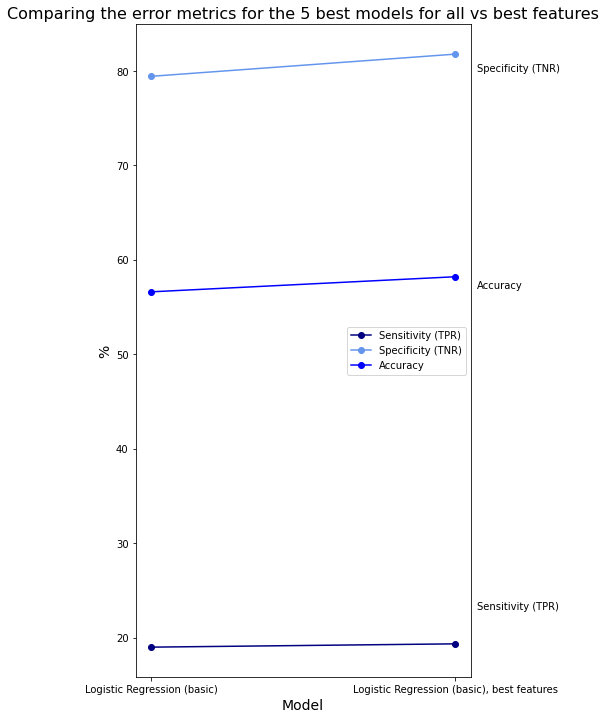

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[6,12])
plt.plot(model_results['Model Description'], model_results['Sensitivity (TPR)'], label='Sensitivity (TPR)', c='navy', marker='o')
plt.plot(model_results['Model Description'], model_results['Specificity (TNR)'], label='Specificity (TNR)', c='cornflowerblue', marker='o')
plt.plot(model_results['Model Description'], model_results['Accuracy'], label='Accuracy', c='b', marker='o')
plt.text(1.07, 80, 'Specificity (TNR)')
plt.text(1.07, 57, 'Accuracy')
plt.text(1.07, 23, 'Sensitivity (TPR)')
plt.title('Comparing the error metrics for the 5 best models for all vs best features', fontdict={'fontsize':16})
plt.ylabel('%', fontdict={'fontsize':14})
plt.xlabel('Model', fontdict={'fontsize':14})
plt.legend()
plt.show()

- As expected, the model is performing slightly better with this selection of 'best features'.
- Our next step will involve going through a few different models and iterating through their parameters to try optimize and output the best models.

---


We have selected the following models since they are the models often used (industry standards) when it comes to Binary Classification data science problems.
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Naive Bayes
5. K-Nearest Neighbor

**Note**: 

- That above list of 'best features' is applicable to the Logistic Regression model. Since we are testing multiple different models, it might be worth implementing a 'best feature selection' step to this next function.   
- However, of these 5 models, only Logistic Regression as a coef_ attribute that works with the best feature selection above.
- With these difficulties taken into account, let's for now choose to keep it simple and just use the above list of best features for all models. 
- Given more time, it would be interesting to try implement this recursive feature selection for each model.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

# for all five models, list a few commonly used parameters options which may be suitable here
def select_model(target, features):
    models = [
        {
            "name": "Logistic Regression",
            "estimator": LogisticRegression(random_state=1, max_iter=500),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "class_weight": ["balanced", None]
                }
        },
        {
            "name": "Decision Tree",
            "estimator": DecisionTreeClassifier(random_state=1),
            "hyperparameters":
                {
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 10],
                    "class_weight": ["balanced", None],
                    "min_samples_split": [2, 5]
                }
        },
        {
            "name": "Random Forest",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [3, 5, 10],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 10],
                    "class_weight": ["balanced", None],
                    "min_samples_split": [2, 5]
                }
        },
        {
            "name": "Naive Bayes",
            "estimator": GaussianNB(),
            "hyperparameters":
                {
                    
                }
        },
        {
            "name": "K-Nearest Neighbor",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(6,20,3),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        }]

    for m in models:        
        print(m['name'])
        grid = GridSearchCV(m['estimator'], param_grid=m['hyperparameters'], cv=10)
        grid.fit(features, target)
        
        m["best_params"] = grid.best_params_
        m["best_score"] = grid.best_score_
        m["best_model"] = grid.best_estimator_
        m["best_cols"] = best_cols
        
        print("Best Score: {}".format(round(m["best_score"], 2)))
        print("Best Parameters: {}\n".format(m["best_params"]))
    
    return models

In [26]:
features = loans[best_cols]
target = pd.Series(loans['loanStatus'])

best_models = select_model(target, features)

Logistic Regression
Best Score: 0.65
Best Parameters: {'class_weight': None, 'solver': 'newton-cg'}

Decision Tree
Best Score: 0.66
Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}

Random Forest
Best Score: 0.66
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}

Naive Bayes
Best Score: 0.63
Best Parameters: {}

K-Nearest Neighbor
Best Score: 0.65
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}



- Now using the 'best models' selected by the GridSearch, we can plug each 'best model' into our function and append to our results table that we created earlier.

---

Let's construct a fresh table.

In [27]:
model_results = pd.DataFrame(columns=['Model Description', 'Sensitivity (TPR)', 'Specificity (TNR)', 'Accuracy'])

# iterate through those best models and append each
for m in best_models:
    model = m['best_model']
    predictions = cross_val_predict(model, features, target, cv=10)
    predictions = pd.Series(predictions)

    model_result = true_false_matrix_output(target, predictions, m['name'])
    model_results = model_results.append(model_result, ignore_index=True)

model_results

,Model Description,Sensitivity (TPR),Specificity (TNR),Accuracy
0,Logistic Regression,19.33,81.77,58.20
1,Decision Tree,20.21,80.92,58.00
2,Random Forest,21.27,79.96,57.80
3,Naive Bayes,3.69,96.48,61.45
4,K-Nearest Neighbor,18.45,82.20,58.13


Okay, let's plot our data that we have so far and see what we can observe and conclude.

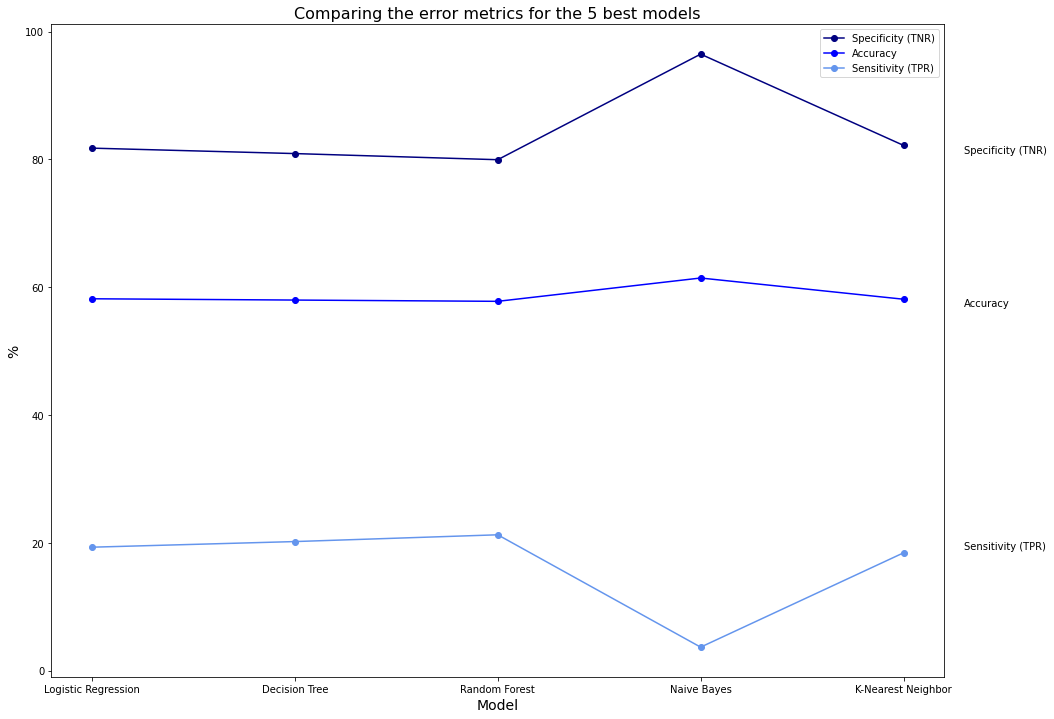

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16,12])
plt.plot(model_results['Model Description'], model_results['Specificity (TNR)'], label='Specificity (TNR)', c='navy', marker='o')
plt.plot(model_results['Model Description'], model_results['Accuracy'], label='Accuracy', c='b', marker='o')
plt.plot(model_results['Model Description'], model_results['Sensitivity (TPR)'], label='Sensitivity (TPR)', c='cornflowerblue', marker='o')
plt.text(4.3, 81, 'Specificity (TNR)')
plt.text(4.3, 57, 'Accuracy')
plt.text(4.3, 19, 'Sensitivity (TPR)')
plt.title('Comparing the error metrics for the 5 best models', fontdict={'fontsize':16})
plt.ylabel('%', fontdict={'fontsize':14})
plt.xlabel('Model', fontdict={'fontsize':14})
plt.legend()
plt.show()

**Observations & Conclusions on Version 1.**

- Our aim was to have a high prediction Accurary, but in particular have a high Specificity (TNR), as this is in line with the 'conservative investor' mindset. 
- With that in mind, one would look at our results and think them a success, since we can consistently achieve a 80%+ Specificity, and an Accuracy of ~58%+. 
- However, when we consider the Sensitivity (TPR), we are only achieving between 18%-22% (with a 3.7% on Naive Bayes!); i.e., we are not approving most of the loans that would have been successful. 
- As suspected from earlier on, since our target column consists of ~61% failures (0s), our model is biased in favour of rejecting more loans. 
- We attempted to counteract this by adding the 'class_weight'='balanced' parameter to the GridSearch, however that parameter proved useless, since in all applicable models, the 'class_weight' was optimised to be left at the default None value.
- Looking at the above graph, we can immediately observe an anomolous result with the Naive Bayes model trained with the Best Features. It looks like this can be easily explained as the model predicting 0 for virtually every single loan, i.e. rejecting all loans... not useful!
- If we had to choose the best model(s), we would probably advise the Decision Tree model, which most balanced of the five, even if the Sensitivity is lacking.

**Next Steps**: At this point, we could hypothesize that the target column we are trying to predict is not ideal, let's move on to trying Version 2 of the analysis.

---

## 6. New Target Column

We will now look to bring in the 'payments.csv' file. This should improve the target column that we are trying to predict, which in turn will hopefully lead to better results. 

**Here is the methodology and thinking:**

Using the payments data, we will construct a new column describing the total amount paid for each loan. From there, we can calculate a ratio of how much of the initial loan amount has been paid off. Then, we can set a threshold point whereby if e.g. 120%+ of the initial loan amount has been paid thus far, that counts as a success, and the rest a failure. The 120% threshold can of course be easily adjusted to meet MoneyLion's business needs. The % threshold would need to take into account things such as:

1. Desired profit margin for MoneyLion.
2. Desire to beat the market and inflation, e.g. a 7% yearly.
3. Money lost if loan goes to Internal / External collections, or Settlements.
    1. A question to ask here is the cost of Collections, both Internally and Externally, since this could be factored in to have a higher % threshold for those loans that have gone through collections.
    2. Likewise with Settlements, what is the typical % reduction in the expected loan repayment if it goes through Settlement, as this can also then be factored into the % threshold.

**Rationale:** The benefit of this V2 target column over V1 is that because of the simple way that V1's target column was constructed, 0 might have been assigned to certain loans that were written off or went for collections despite still having paid out 150% or 200% of the initial loan amount. 

I.e., even though a loan was written off, MoneyLion still would have been happy to give that loan considering they had made X% money on it above the initial funded amount. And to reiterate, anything below a certain % threshold would be considered a failure and assigned 0.

---

Let's begin by loading in a fresh loans dataset and performing very similar data cleaning and feature engineering steps. 

**Note:** we'll only properly comment where the steps differ from what we have previously done for V1 of the model.

In [30]:
# load data
loans = pd.read_csv(r'C:\Users\Panda\Documents\4 Coding & Work\5 MoneyLion\data\data\loan.csv')

# drop future-leaking columns
drop_cols = ['originated', 'originatedDate', 'approved', 'isFunded', 'fpStatus']
loans.drop(columns=drop_cols, inplace=True)

# again, we will only be keeping the same columns 
loans = loans[(loans['loanStatus'] == 'Paid Off Loan') |
              (loans['loanStatus'] == 'External Collection') |
              (loans['loanStatus'] == 'Internal Collection') |
              (loans['loanStatus'] == 'Settlement Paid Off') |
              (loans['loanStatus'] == 'Settled Bankruptcy') |
              (loans['loanStatus'] == 'Charged Off Paid Off') |
              (loans['loanStatus'] == 'Settlement Pending Paid Off') |
              (loans['loanStatus'] == 'Charged Off')
             ]

###
# This time, we won't be assigning the binary values yet, since we will be building a new target column.
# For now, we'll continue with the rest of the same cleaning and engineering steps, and we'll bring in
# the new target column at after.
###

# drop unique columns
drop_cols = []
for col in loans.columns:
    col_vals = loans[col].dropna()      # first, remove the N/As
    col_unique_vals = col_vals.unique() # get a list of unique values
    if len(col_unique_vals) == 1:       # check if there is just 1 unique value
        drop_cols.append(col)
loans.drop(columns=drop_cols, inplace=True)


# drop N/As
loans.dropna(axis=0, inplace=True, subset=['payFrequency', 'nPaidOff'])

# fix the date
loans['applicationDate'] = loans['applicationDate'].str[:10]
loans['applicationDate'] = pd.to_datetime(loans['applicationDate'])

# add the counter for anon_ssn
loans.sort_values(by=['applicationDate'], inplace=True)
freq_ssn = {} # frequency dictionary
cont_ssn = [] # counter to add as a feature column

for i in loans['anon_ssn']:
    if i in freq_ssn:
        freq_ssn[i] += 1
    else:
        freq_ssn[i] = 1
    cont_ssn.append(freq_ssn[i])
loans['anon_ssn'] = cont_ssn

# categorise the states column
states_dict = {}
for key in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']:
    states_dict[key] = 'newEngland'
for key in ['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']:
    states_dict[key] = 'mideast'
for key in ['IL', 'IN', 'MI', 'OH', 'WI']:
    states_dict[key] = 'greatLakes'
for key in ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
    states_dict[key] = 'plains'
for key in ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']:
    states_dict[key] = 'southeast'
for key in ['AZ', 'NM', 'OK', 'TX']:
    states_dict[key] = 'southwest'
for key in ['CO', 'ID', 'MT', 'UT', 'WY']:
    states_dict[key] = 'rockyMountain'
for key in ['AK', 'CA', 'HI', 'NV', 'OR', 'WA']:
    states_dict[key] = 'farWest'
loans['state'].replace(states_dict, inplace=True)

# encode the categorical columns
dummies_cols = ['payFrequency', 'leadType', 'state']
for col in dummies_cols:
    dummy_df = pd.get_dummies(loans[[col]])
    loans = pd.concat([loans, dummy_df], axis=1)
    loans.drop(columns=col, inplace=True)

# alright, that should be all the cleaning and engineering
loans.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_rc_returning,leadType_repeat,state_farWest,state_greatLakes,state_mideast,state_newEngland,state_plains,state_rockyMountain,state_southeast,state_southwest
141517,LL-I-00003578,1,478.67,2014-12-04,1.0,Paid Off Loan,800.0,1919.28,25,NaN,...,0,0,0,1,0,0,0,0,0,0
514411,LL-I-00003606,1,478.67,2014-12-04,0.0,Paid Off Loan,900.0,2283.38,25,NaN,...,0,0,0,1,0,0,0,0,0,0
156805,LL-I-00004745,1,478.67,2014-12-05,0.0,Settlement Paid Off,500.0,1199.55,25,NaN,...,0,0,0,1,0,0,0,0,0,0
381928,LL-I-00003728,1,478.67,2014-12-05,0.0,External Collection,500.0,1272.00,6,NaN,...,0,0,0,1,0,0,0,0,0,0
67812,LL-I-00004311,1,478.67,2014-12-05,0.0,External Collection,700.0,1775.95,25,NaN,...,0,0,0,1,0,0,0,0,0,0
541162,LL-I-00004803,1,478.67,2014-12-05,0.0,External Collection,500.0,1272.00,25,NaN,...,0,0,0,1,0,0,0,0,0,0
485235,LL-I-00004684,1,478.67,2014-12-05,0.0,External Collection,500.0,1268.52,25,NaN,...,0,0,0,1,0,0,0,0,0,0
416885,LL-I-00003773,1,442.89,2014-12-05,1.0,Paid Off Loan,1000.0,2277.44,6,NaN,...,0,0,0,1,0,0,0,0,0,0
484468,LL-I-00003732,1,570.32,2014-12-05,1.0,Paid Off Loan,400.0,1087.90,10,NaN,...,0,0,0,1,0,0,0,0,0,0
352358,LL-I-00003721,1,478.67,2014-12-05,0.0,External Collection,800.0,1919.28,6,NaN,...,0,0,0,1,0,0,0,0,0,0


- Great, we have our loans dataset in a good state. 

---

Now, we will look to implement this new target column as described above. To do so, we'll use SQL.

In [31]:
import sqlite3

# install the ipython-sql libray
!pip install ipython-sql

In [32]:
# load the payments data
payments = pd.read_csv(r'C:\Users\Panda\Documents\4 Coding & Work\5 MoneyLion\data\data\payment.csv')

# create a connection to sqlite3 
conn = sqlite3.connect('jupyter_moneylion.db')

In [33]:
# add the loans table to SQL
# loans.to_sql('loans', conn) 
##### need to comment out the above line since I have already added the table to the SQL location

In [34]:
# add the payments table to SQL
# payments.to_sql('payments', conn) 
##### need to comment out the above line since I have already added the table to the SQL location

In [35]:
%load_ext sql

In [36]:
%sql sqlite:///jupyter_moneylion.db

In [37]:
query = """
WITH total_paid_table AS
    (
    SELECT loanID, SUM(paymentAmount) AS totalPaid, 1 AS loanIDCheck
     FROM payments
    WHERE paymentStatus = 'Checked'
    GROUP BY loanID
    )

SELECT l.*, t.totalPaid
  FROM loans as l
  LEFT JOIN total_paid_table as t
    ON l.loanID = t.loanID
"""

loans = pd.read_sql(query, conn)
loans.head()

,index,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,...,leadType_repeat,state_farWest,state_greatLakes,state_mideast,state_newEngland,state_plains,state_rockyMountain,state_southeast,state_southwest,totalPaid
0,141517,LL-I-00003578,1,478.67,2014-12-04 00:00:00,1.0,Paid Off Loan,800.0,1919.28,25,...,0,0,1,0,0,0,0,0,0,1135.20
1,514411,LL-I-00003606,1,478.67,2014-12-04 00:00:00,0.0,Paid Off Loan,900.0,2283.38,25,...,0,0,1,0,0,0,0,0,0,2330.71
2,156805,LL-I-00004745,1,478.67,2014-12-05 00:00:00,0.0,Settlement Paid Off,500.0,1199.55,25,...,0,0,1,0,0,0,0,0,0,1162.74
3,381928,LL-I-00003728,1,478.67,2014-12-05 00:00:00,0.0,External Collection,500.0,1272.00,6,...,0,0,1,0,0,0,0,0,0,NaN
4,67812,LL-I-00004311,1,478.67,2014-12-05 00:00:00,0.0,External Collection,700.0,1775.95,25,...,0,0,1,0,0,0,0,0,0,NaN


- Immediately we see the issue of N/As populating this new column. 
- Upon spot checking in Excel, it looks like those N/As are where there is a corresponding loanID, however no 'Checked' payments whatsoever. 

Let's replace all N/As with 0, indiating that no payments have been made for that specific loan.

In [38]:
loans['totalPaid'].fillna(0, inplace=True)

---

Next, we'll need to construct our new ratio column by dividing the **totalPaid** by the initial **loanAmount**.

In [39]:
loans['paidRatio'] = loans['totalPaid']/loans['loanAmount']

In order to decide the % threshold, we'll need to analyse this new **paidRatio** column further. Let's also create another new **expectedRatio** column by dividing the **originallyScheduledPaymentAmount** by the **initial loanAmount**, to see what MoneyLion were expecting to get back.

We will analyse these two ratio columns in conjunction with each other.

In [40]:
loans['expectedRatio'] = loans['originallyScheduledPaymentAmount']/loans['loanAmount']

# summary statistics for these columns
loans[['paidRatio', 'expectedRatio']].describe()

,paidRatio,expectedRatio
count,29502.000000,29502.000000
mean,1.129356,2.768722
std,0.958277,0.523045
min,0.000000,1.000000
25%,0.246629,2.304573
50%,1.010743,2.894141
75%,1.872900,3.148400
max,6.331133,7.299911


---

Let's plot a comparitive histogram to try get a better sense of the % threshold to be assigned.

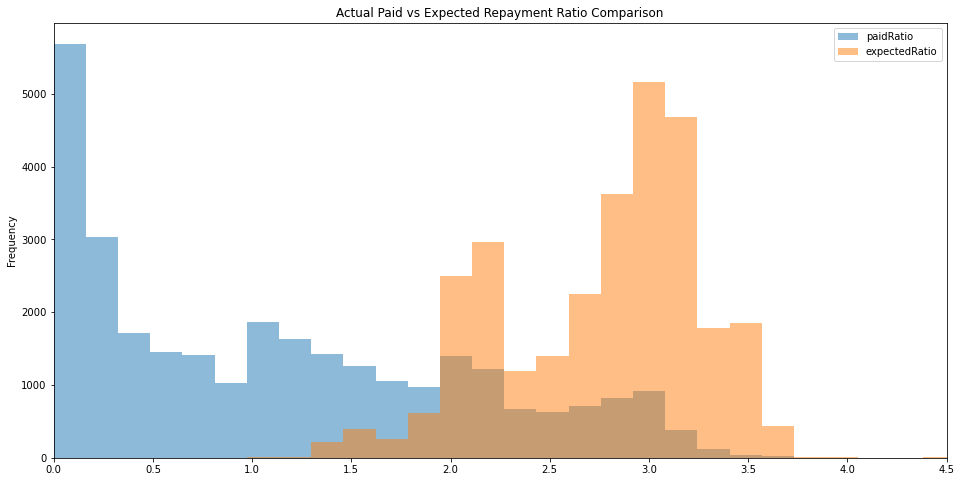

In [41]:
loans[['paidRatio', 'expectedRatio']].plot.hist(alpha=0.5,bins=45, figsize=(16, 8),
                                                title='Actual Paid vs Expected Repayment Ratio Comparison',
                                                xlim=[0, 4.5]) # beyond 4.5 are only a few outliers, not worth displaying
plt.show()

- It looks like there are a LOT of loans that end up paying off below 100% of the initial funded amount. 
- This is somewhat in line with our previous V1 analysis whereby ~61% of the loans were considered as 'fail'. 

Before assigning a % threshold, let's zoom in on the loans with 'Paid Off Loan' status (the ones that were previously considered as 'success'. 

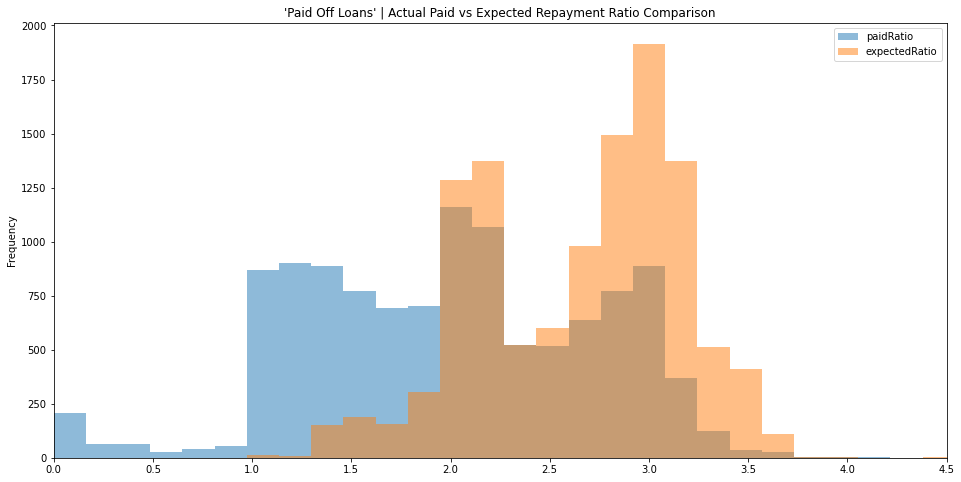

In [42]:
paid_loans = loans[loans['loanStatus'] == 'Paid Off Loan']
paid_loans[['paidRatio', 'expectedRatio']].plot.hist(alpha=0.5,bins=45, figsize=(16, 8),
                                                     title="'Paid Off Loans' | Actual Paid vs Expected Repayment Ratio Comparison",
                                                     xlim=[0, 4.5])
plt.show()

- Curiously, there are quite a few loans in this status that ended up paying back less than 100% of the original funded amount. - This does raise some questions that going forward would be good to investigate further with MoneyLion.
- For now, let's leave these ones in since we do not have much more information to go off.
- More importantly, there are a large number of these fully paid off loans that fall within 100% to 200% of the original funded amount, much lower than the expected amounts. This is likely due to the majority of these loans being paid off early.

---

With these numbers and graphs in mind, let's bring back the first histogram above and add in a line to indicate a 130% threshold:

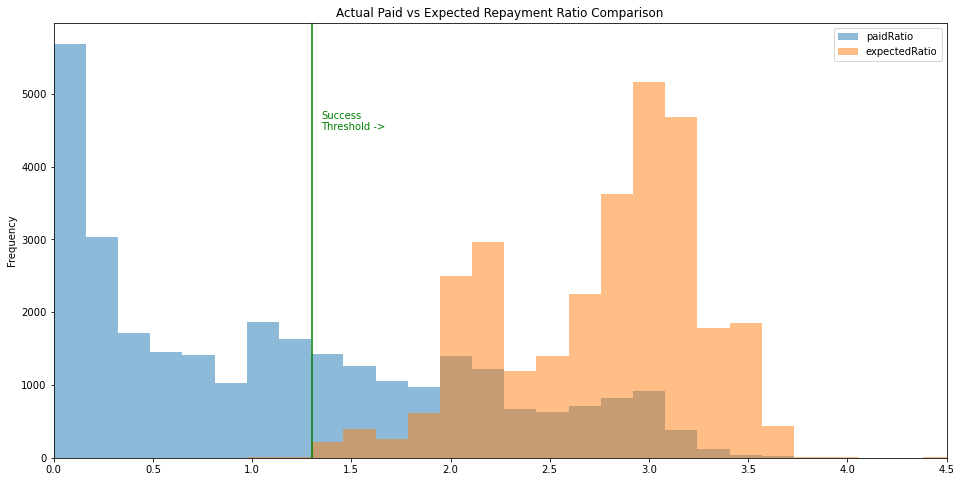

In [43]:
loans[['paidRatio', 'expectedRatio']].plot.hist(alpha=0.5,bins=45, figsize=(16, 8),
                                                title='Actual Paid vs Expected Repayment Ratio Comparison',
                                                xlim=[0, 4.5])
plt.axvline(1.3, c='g')
plt.text(1.35, 4500, 'Success\nThreshold ->', c='g')
plt.show()

This threshold makes sense since (besides a few outliers), almost all expected loan repayment ratios fall above this line. Perhaps 130% is MoneyLion's minimum expected return on a loan repayment? 

---

- We'll take x < 1.3 (exclusive) as the cutoff point to assign the target column as 0 (a fail).
- All ratios x >= 1.3 (inclusive) will be classed as a 1 (success) and then we will repeat the same modelling steps as with V1.

We'll use the same target column **loanStatus** just to avoid re-working our previous modelling code.

In [44]:
# first, assign all 1s
loans['loanStatus'] = 1

# then, assign 0s to anything less than 1.3
loans.loc[loans['paidRatio'] < 1.3, 'loanStatus'] = 0 

# check the distribution, as we did with V1
status_col = pd.DataFrame(loans['loanStatus'].value_counts())
status_col['%'] = round(100*loans['loanStatus'].value_counts(normalize=True),3) # add the % of that result
status_col

,loanStatus,%
0,17842,60.477
1,11660,39.523


- Okay, this distribution is pretty much just as biased as our V1 dataset (which had ~61% failures). 
- Let's hope that our modelling with this new target column can produce better results.

---

Again, we'll just run similar repeated steps as before, and we'll comment as necessary.

In [45]:
# let's redefine the features and target column
features = loans.drop(columns=['loanId', 'applicationDate', 'loanStatus', 'clarityFraudId',
                               'totalPaid', 'paidRatio', 'expectedRatio'])  # we need to drop these newly added columns
target = pd.Series(loans['loanStatus'])

# let's now find the 'best features' for this V2 data
lr = LogisticRegression(max_iter=500)
selector = RFECV(lr, cv=10)
selector.fit(features, target)
v2_best_cols = list(features.columns[selector.support_])

In [46]:
# assign this new set of columns
features = loans[v2_best_cols]

# find the best models' parameters
v2_best_models = select_model(target, features)

Logistic Regression
Best Score: 0.62
Best Parameters: {'class_weight': None, 'solver': 'newton-cg'}

Decision Tree
Best Score: 0.63
Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

Random Forest
Best Score: 0.62
Best Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 10}

Naive Bayes
Best Score: 0.58
Best Parameters: {}

K-Nearest Neighbor
Best Score: 0.58
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}



In [56]:
# populate our results table for main features
v2_model_results = pd.DataFrame(columns=['Model Description', 'Sensitivity (TPR)', 'Specificity (TNR)', 'Accuracy'])
for m in v2_best_models:
    model = m['best_model']
    predictions = cross_val_predict(model, features, target, cv=10)
    predictions = pd.Series(predictions)

    model_result = true_false_matrix_output(target, predictions, m['name'])
    
    # here let's introduce a new result metric: the revenue on the loan
    predictions_bool = predictions.replace({0:False, 1:True})
    predicted_loans = loans[predictions_bool.values]
    revenue = predicted_loans['totalPaid'].sum() - predicted_loans['loanAmount'].sum()
    model_result['Revenue'] = revenue
    
    v2_model_results = v2_model_results.append(model_result, ignore_index=True)

- A new result metric has been introduced in the code block above: Revevue. 
- It is conmprised of the sum total of money gained subtract money lost through following the predicted loans

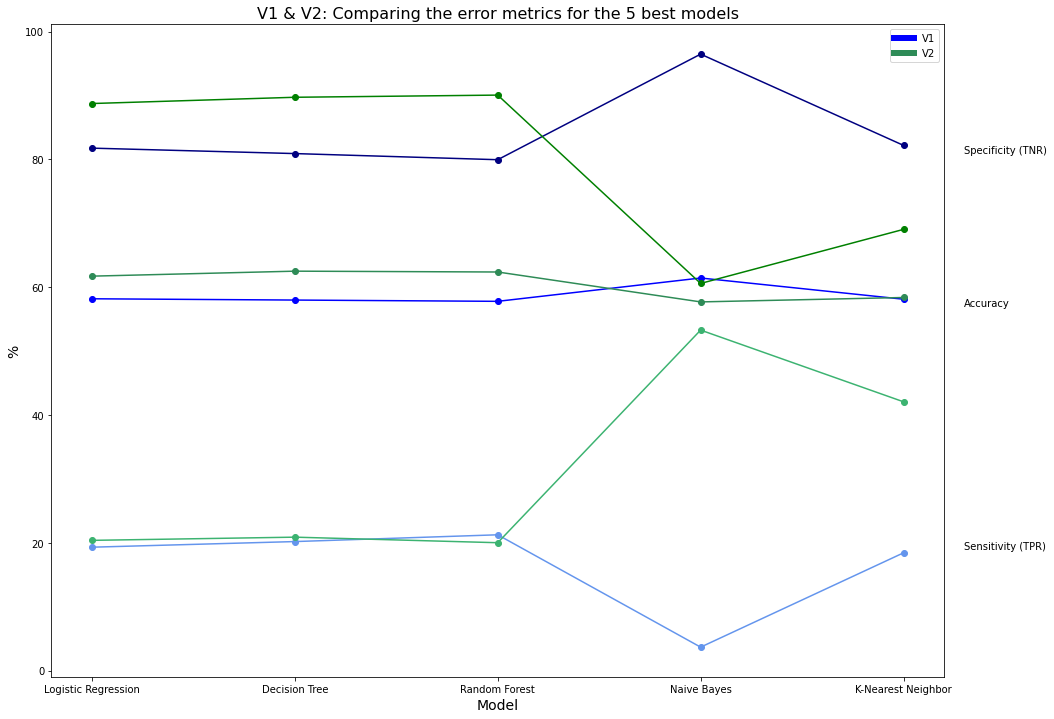

In [48]:
# plot our new data
%matplotlib inline

plt.figure(figsize=[16,12])
# keep the previous V1 data
plt.plot(model_results['Model Description'], model_results['Specificity (TNR)'], label='Specificity (TNR)', c='navy', marker='o')
plt.plot(model_results['Model Description'], model_results['Accuracy'], label='Accuracy', c='b', marker='o')
plt.plot(model_results['Model Description'], model_results['Sensitivity (TPR)'], label='Sensitivity (TPR)', c='cornflowerblue', marker='o')
# add the V2 data
plt.plot(v2_model_results['Model Description'], v2_model_results['Specificity (TNR)'], label='Specificity (TNR)', c='g', marker='o')
plt.plot(v2_model_results['Model Description'], v2_model_results['Accuracy'], label='Accuracy', c='seagreen', marker='o')
plt.plot(v2_model_results['Model Description'], v2_model_results['Sensitivity (TPR)'], label='Sensitivity (TPR)', c='mediumseagreen', marker='o')
plt.text(4.3, 81, 'Specificity (TNR)')
plt.text(4.3, 57, 'Accuracy')
plt.text(4.3, 29, 'Sensitivity (TPR)')
plt.title('V1 & V2: Comparing the error metrics for the 5 best models', fontdict={'fontsize':16})
plt.ylabel('%', fontdict={'fontsize':14})
plt.xlabel('Model', fontdict={'fontsize':14})
# for a custom legend
from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], c='b', lw=6),
                Line2D([0], [0], c='seagreen', lw=6)]
plt.legend(legend_lines, ['V1', 'V2'])
plt.show()

In [63]:
# display our new data alongside our previous tables
from IPython.display import display_html 

df1_styler = model_results.style.set_table_attributes("style='display:inline'").set_caption('V1 Results')
df2_styler = v2_model_results.style.set_table_attributes("style='display:inline'").set_caption('V2 Results')
space = "\xa0" * 8

display_html(df1_styler._repr_html_() + space + df2_styler._repr_html_(), raw=True)

V1 Results Model Description Sensitivity (TPR) Specificity (TNR) Accuracy 
 
 0 
 Logistic Regression 
 19.330000 
 81.770000 
 58.200000 
 
 
 1 
 Decision Tree 
 20.210000 
 80.920000 
 58.000000 
 
 
 2 
 Random Forest 
 21.270000 
 79.960000 
 57.800000 
 
 
 3 
 Naive Bayes 
 3.690000 
 96.480000 
 61.450000 
 
 
 4 
 K-Nearest Neighbor 
 18.450000 
 82.200000 
 58.130000 
 
          V2 Results Model Description Sensitivity (TPR) Specificity (TNR) Accuracy Revenue 
 
 0 
 Logistic Regression 
 20.400000 
 88.750000 
 61.740000 
 1089889.340000 
 
 
 1 
 Decision Tree 
 20.900000 
 89.730000 
 62.520000 
 1170192.110000 
 
 
 2 
 Random Forest 
 20.030000 
 90.070000 
 62.390000 
 1105050.840000 
 
 
 3 
 Naive Bayes 
 53.300000 
 60.600000 
 57.710000 
 1881815.490000 
 
 
 4 
 K-Nearest Neighbor 
 42.080000 
 69.060000 
 58.400000 
 1668495.770000

#### Observations & Conclusions on Version 2:

- Firstly, we can see the new Revenue metric added to the V2 Results table, since we have now brought in the payment.csv data. This adds a new twist to the observations we might make.
- Most notably, the two models that we would normally consider do the worst are actually making the most revenue. This is most likely due to the fact that Sensitivity (TPR) is much higher, whereby simply approving more loans means more money gained on the successful loans relative to the money lost on the failed ones.
    - As a next step, this might encourage us to adjust the % threshold (since we want to be approving more loans in general).
    - Given more time and info from MoneyLion, we could suggest to decrease the threshold to 120%, 110%, and even try 100% (it is currently set at 130%), which would result in more loans being predicted as approve.
- Besides the Revenue metric, this time either the Decision Tree or Random Forest look to be the better models when it comes to accurately predicting loan repayment. 
- In fact, this model's accuracy is now outperforming the baseline of 60.5% (which is the % of failures (0) in this dataset). 

---

## 7. Overall Conclusions

- This has been an in-depth look into how to predict loans repayments and whether or not we should approve loans given a set of information about the person and the loan application. 
- V2 of the analysis was definitely a set up in the model prediction quality, and there are some clear next steps here too.
- Firstly, to summarise the results:
    - When assessing with regards to pure model performance (Accuracy, Specificity and Sensitivity), across the board: Logistic Regression, Decision Tree and Random Forest have all been fairly consistently well performing models. With the latter two coming out on top by a small margin.
    - However, with the new metric of Revenue, this flips the results completely. Rather, Naive Bayes and K-Nearest Neighbor are the supreme models, with the former being the best revenue generator (despite having the lowest Accuracy and the worst Specificity by some margin).
    - Simply by approving more loans in general, Naive Bayes is making more money off the successful loans than it is losing from the failures. 
    
---

#### This leads to two key Next Steps:
1. The more simple Next Step is to re-run the V2 analysis whilst readjusting and optimising the % threshold from 130% to somewhere between 120%, 110%, and even 100%. This could quite easily show further gains in Revenue generated.
2. The more complex Next Step would involve once again iterating the target column to a Version 3.
    1. This time rather than using the paidRatio as a threshold for binary asignment, instead use its value to assign a weight to the paidRatio
    2. This would further incentivise the model to look for the big gain loans and avoid the total losses.
    3. This would be a time-consuming next step, particularly since it would no longer be a Binary Classification problem and thus would require much rework for the modelling portion. Hence why, unfortunately, there was not enough time to explore this further this time. 
    
---

Many thanks for reading. Any thoughts and feedback are always welcome & appreciated.

Andrew Day